In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("datasets/songs.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2661 entries, 0 to 2660
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2661 non-null   object 
 1   name              2661 non-null   object 
 2   valence           2661 non-null   float64
 3   year              2661 non-null   int64  
 4   acousticness      2661 non-null   float64
 5   danceability      2661 non-null   float64
 6   duration_ms       2661 non-null   int64  
 7   energy            2661 non-null   float64
 8   explicit          2661 non-null   int64  
 9   instrumentalness  2661 non-null   float64
 10  key               2661 non-null   int64  
 11  liveness          2661 non-null   float64
 12  loudness          2661 non-null   float64
 13  mode              2661 non-null   int64  
 14  popularity        2661 non-null   int64  
 15  speechiness       2661 non-null   float64
 16  tempo             2661 non-null   float64


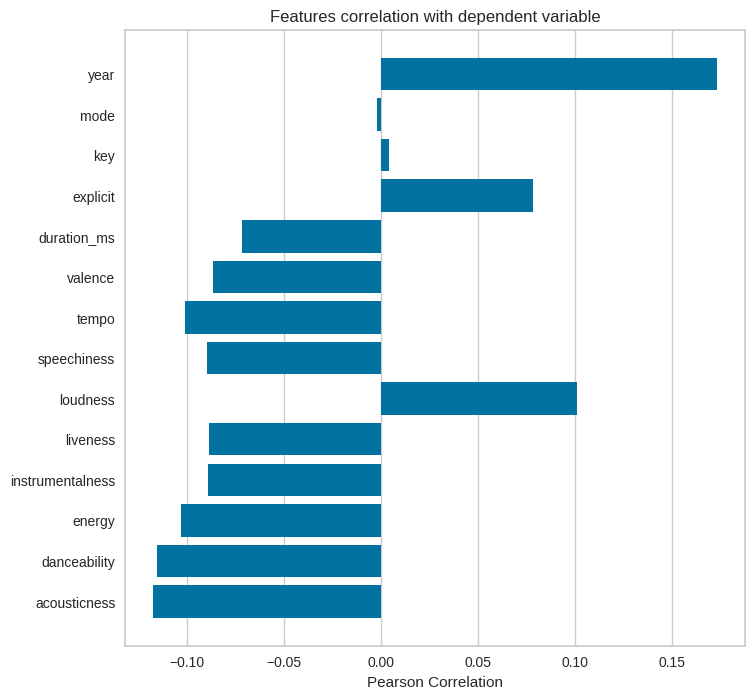

In [3]:
from yellowbrick.target import FeatureCorrelation

features_list = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

# Estrazione delle caratteristiche e la variabile target 'popularity' dal dataset
X, y = data[features_list], data['popularity']

features = np.array(features_list)
visualizer = FeatureCorrelation(labels=features)
plt.rcParams['figure.figsize'] = (8, 8)

visualizer.fit(X, y)
visualizer.show()
plt.show()

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import plotly.express as px

X = data.select_dtypes(np.number)
cluster_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('kmeans', KMeans(n_clusters=10, random_state=42))
])

cluster_pipeline.fit(X)
data['cluster'] = cluster_pipeline.predict(X)

# Sistema di raccomandazione

In [5]:
import spotipy
import difflib
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

client_id = 'cd0f7e9279034469a5c4560808cb31a8' 
client_secret = 'da3fe74efc5c4a84b71399c157366e09'
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

In [6]:
from collections import defaultdict
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

def get_song_data(song_id, spotify_data):
    song_data = spotify_data[spotify_data['id'] == song_id]
    if song_data.empty:
          return None
    return song_data.reset_index(drop=True)  # Converti in DataFrame e resetta l'indice

# Funzione per calcolare il vettore medio dei brani nella lista
def get_mean_vector(song_list, spotify_data):
    song_vectors = []
    for song_id in song_list:
        song_data = get_song_data(song_id, spotify_data)
        if song_data is not None:
            numeric_data = song_data.select_dtypes(include=np.number)
            if numeric_data.shape[0] > 0:  # Verifica se ci sono dati numerici nel brano
                song_vector = numeric_data.mean().values  # Calcola la media delle caratteristiche numeriche
                song_vectors.append(song_vector)
            else:
                print('Warning: Song with ID {} has no numeric data'.format(song_id))
        else:
            print('Warning: Song with ID {} does not exist in the database'.format(song_id))
    if song_vectors:
        song_matrix = np.array(song_vectors)
        return np.mean(song_matrix, axis=0)
    else:
        return None

def recommend_songs(song_list, spotify_data, test_set, n_songs=5):
    song_center = get_mean_vector(song_list, spotify_data)
    if song_center is None:
        print("No songs found for recommendation.")
        return None
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(test_set.select_dtypes(include=['float64', 'int64']))
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[0])  # Ordina gli indici in base alla distanza
    rec_songs = test_set.iloc[index]
    unique_rec_songs = rec_songs.drop_duplicates(subset='id')  # Rimuovi duplicati basati sull'ID della canzone
    n_unique = len(unique_rec_songs)
    if n_unique < n_songs:  # Se ci sono meno suggerimenti unici di quelli richiesti
        additional_songs = []
        idx = n_unique
        while len(unique_rec_songs) < n_songs and idx < len(test_set):
            if test_set.iloc[idx]['id'] not in unique_rec_songs['id'].values:
                unique_rec_songs = unique_rec_songs.append(test_set.iloc[idx])
            idx += 1
    return unique_rec_songs.head(n_songs)

## K-MEANS

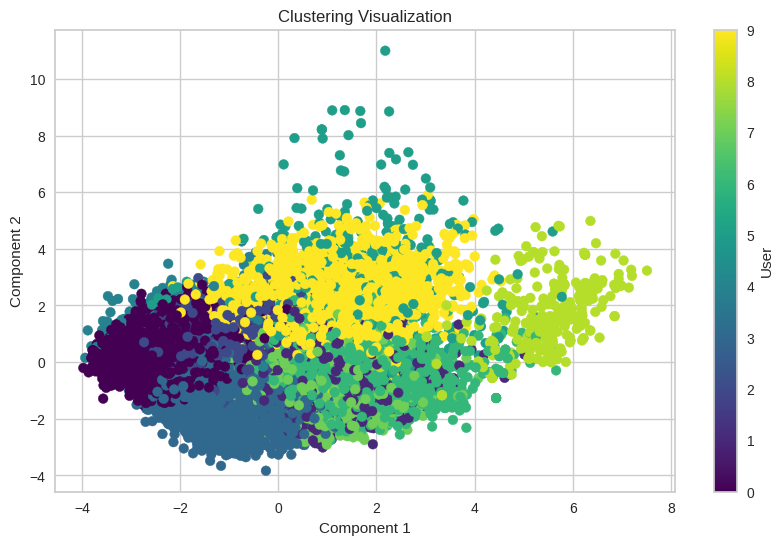

,id,name,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,user
0,767rTyArhkBMH2BlNltSwv,"Nocturnes, Op. 62: No. 1 in B Major",0.0745,1946,993.000,352.00,382693.0,0.0863,0.0,914.000000,11.0,116.00,-22517.00,1.0,0.0,0.0429,138594.000,user_1
1,7rCWSuOg9Sl36L8VOlewPr,Bidaysandhya Aasilo Oi,261.0000,1931,989.000,395.00,198760.0,191.0000,0.0,0.920000,8.0,227.00,-16665.00,1.0,0.0,0.0355,71622.000,user_1
2,6Vwp6sHOckhoyC5SZ1R6Qu,"Silent Night, Holy Night",0.0754,1958,517.000,138.00,141947.0,107.0000,0.0,939.000000,5.0,0.11,-23297.00,1.0,17.0,0.0437,82727.000,user_1
3,2wfsMJSCSg7wkjZaTNnNfz,"Estampes, L. 100: III. Jardins sous la pluie -...",38.0000,1941,0.990,0.27,217587.0,0.1690,0.0,868.000000,4.0,88.00,-19028.00,1.0,0.0,0.0328,86459.000,user_1
4,3xKFyZH2u4oj57WVaRBd1C,"Theme from ""The Dark At the Top of the Stairs""",231.0000,1961,0.641,271.00,155707.0,0.3200,0.0,912.000000,5.0,158.00,-15968.00,1.0,24.0,0.0334,92.920,user_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24712,4rpMuF6Z28knTQCUpUfH3D,Sweetest Of All,522.0000,1978,0.761,479.00,160933.0,575.0000,0.0,0.000008,10.0,728.00,-8.65,1.0,36.0,35.0000,142.271,user_10
24713,0q0cKtWbDbAeVrtql6lkB2,I Forgot to Remember to Forget,674.0000,1959,401.000,679.00,148320.0,471.0000,0.0,0.000018,4.0,552.00,-12643.00,1.0,30.0,0.0577,112946.000,user_10
24714,5DBcXvFP2EsYDah9aii1tH,Tu Amor Soñado,852.0000,1972,0.620,388.00,151333.0,0.5530,0.0,0.000008,5.0,638.00,-4681.00,1.0,26.0,0.0343,135007.000,user_10
24715,5PkkrqACWO9yK0h2LrDwqg,Drug Store Truck Drivin' Man,0.7660,1969,635.000,531.00,233173.0,498.0000,0.0,0.000004,2.0,578.00,-11066.00,1.0,26.0,0.0275,138806.000,user_10


In [12]:
name = '7.csv'

data = pd.read_csv(name)

numeric_columns = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'popularity', 'speechiness', 'tempo']
numeric_data = data[numeric_columns]
            
# Standardizza i dati
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Crea il modello PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Crea il modello K-means con il numero di cluster desiderato (k)
k = 10  # Scegli un valore adeguato per k
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)

# Assegna le etichette dei cluster ai record
data['user'] = kmeans.labels_

# Visualizza i cluster
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=data['user'], cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Clustering Visualization')
plt.colorbar(label='User')
plt.show()

# Sistemo le etichette nel dataset 
data['user'] = [f'user_{i+1}' for i in kmeans.labels_] 

# Definisci una funzione di ordinamento personalizzata per le etichette 'user'
def custom_sort(user_label):
    # Estrai il numero dalla etichetta 'user'
    num = int(user_label.split('_')[1])
    return num

# Ordina il DataFrame utilizzando la funzione di ordinamento personalizzata
data['user_numeric'] = data['user'].apply(custom_sort)
data = data.sort_values(by='user_numeric').drop(columns='user_numeric').reset_index(drop=True)

data.head(-5)
#data.to_csv(name)

In [8]:
from sklearn.model_selection import train_test_split

#data = pd.read_csv('datasets/data.csv')
users = data['user'].unique()

train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Per ogni utente, divide i dati in set di training e test e aggiungi ai set totali
for user in users:
    user_data = data[data['user'] == user]
    user_train, user_test = train_test_split(user_data, test_size=0.2, random_state=42)
    train_data = pd.concat([train_data, user_train])
    test_data = pd.concat([test_data, user_test])

In [9]:
def evaluate_precision(user, recommended_songs, test_data):
    test_songs = test_data[test_data['user'] == user]['id'].tolist()

    relevant_songs = set(test_songs)
    recommended_songs = set(recommended_songs['id'])

    precision = len(recommended_songs & relevant_songs) / len(recommended_songs)
    recall = len(recommended_songs & relevant_songs) / len(relevant_songs)
    f1_score = (2 * precision * recall)/(precision + recall) if (precision + recall) != 0 else 0

    return round(precision, 2)

In [10]:
from sklearn.model_selection import train_test_split

users = data['user'].unique()

# Per ogni utente, divide i dati in set di training e test e calcola le metriche
i = 0
for user in users:
    i += 1
    user_data = data[data['user'] == user]
    user_train, user_test = train_test_split(user_data, test_size=0.2, random_state=42)

    recommended_songs = recommend_songs(user_train['id'].tolist(), data, test_data, n_songs=len(user_test))
    #if i==12:
     #   break

#print(f"Predette: \n{recommended_songs['name']}\n")
#print(f"Reali:\n {user_test['name']}")

# Calcola la precisione e il recall
    precision = evaluate_precision(user, recommended_songs, user_test)
    print(f"Precision for user {user}: {precision}")
#print(f"Recall for user {user}: {recall}")
#print(f"F1-score for user {user}: {f1_score}\n")

Precision for user user_1: 0.83
Precision for user user_10: 0.9
Precision for user user_2: 0.84
Precision for user user_3: 0.67
Precision for user user_4: 0.8
Precision for user user_5: 0.8
Precision for user user_6: 0.91
Precision for user user_7: 0.82
Precision for user user_8: 0.77
Precision for user user_9: 0.97
